In [15]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# load datasets
train = pd.read_csv("btrain.csv")
val = pd.read_csv("bvalidate.csv")
test = pd.read_csv("btest.csv")

In [16]:
train = pd.read_csv("btrain.csv")
print("Columns in training data:", train.columns.tolist())

Columns in training data: ['winpercent', ' oppwinpercent', ' weather', ' temperature', ' numinjured', ' oppnuminjured', ' startingpitcher', ' oppstartingpitcher', ' dayssincegame', ' oppdayssincegame', ' homeaway', ' rundifferential', ' opprundifferential', ' winner']


In [3]:
# strip whitespace
train.columns = train.columns.str.strip()
val.columns = val.columns.str.strip()
test.columns = test.columns.str.strip()

features = train.columns.drop("winner")
target = "winner"

# separate features and target
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# convert numeric columns (with error handling)
numeric_cols = ["winpercent", "oppwinpercent", "temperature", "numinjured",
                "oppnuminjured", "dayssincegame", "oppdayssincegame",
                "rundifferential", "opprundifferential"]
categorical_cols = ["weather", "startingpitcher", "oppstartingpitcher", "homeaway"]

for col in numeric_cols:
    for df in [X_train, X_val, X_test]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# enhanced preprocessing
numeric_transformer = Pipeline(steps=[
    # fill in missing values with column's median value
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# handle potential NaN in target
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]

# fit and transform
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# final check for NaN
assert not np.isnan(X_train_processed).any(), "Training data still contains NaN!"
assert not np.isnan(X_val_processed).any(), "Validation data still contains NaN!"

<ipython-input-3-2288bec9b091>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors="coerce")


In [17]:
# train decision tree
clf = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=5)
clf.fit(X_train_processed, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [18]:
# evaluate accuracy
val_pred = clf.predict(X_val_processed)
print(f"Validation Accuracy: {accuracy_score(y_val, val_pred):.4f}")

Validation Accuracy: 0.8636


In [19]:
test_pred = clf.predict(X_test_processed)
test["winner"] = test_pred
test.to_csv("test_predictions.csv", index=False)


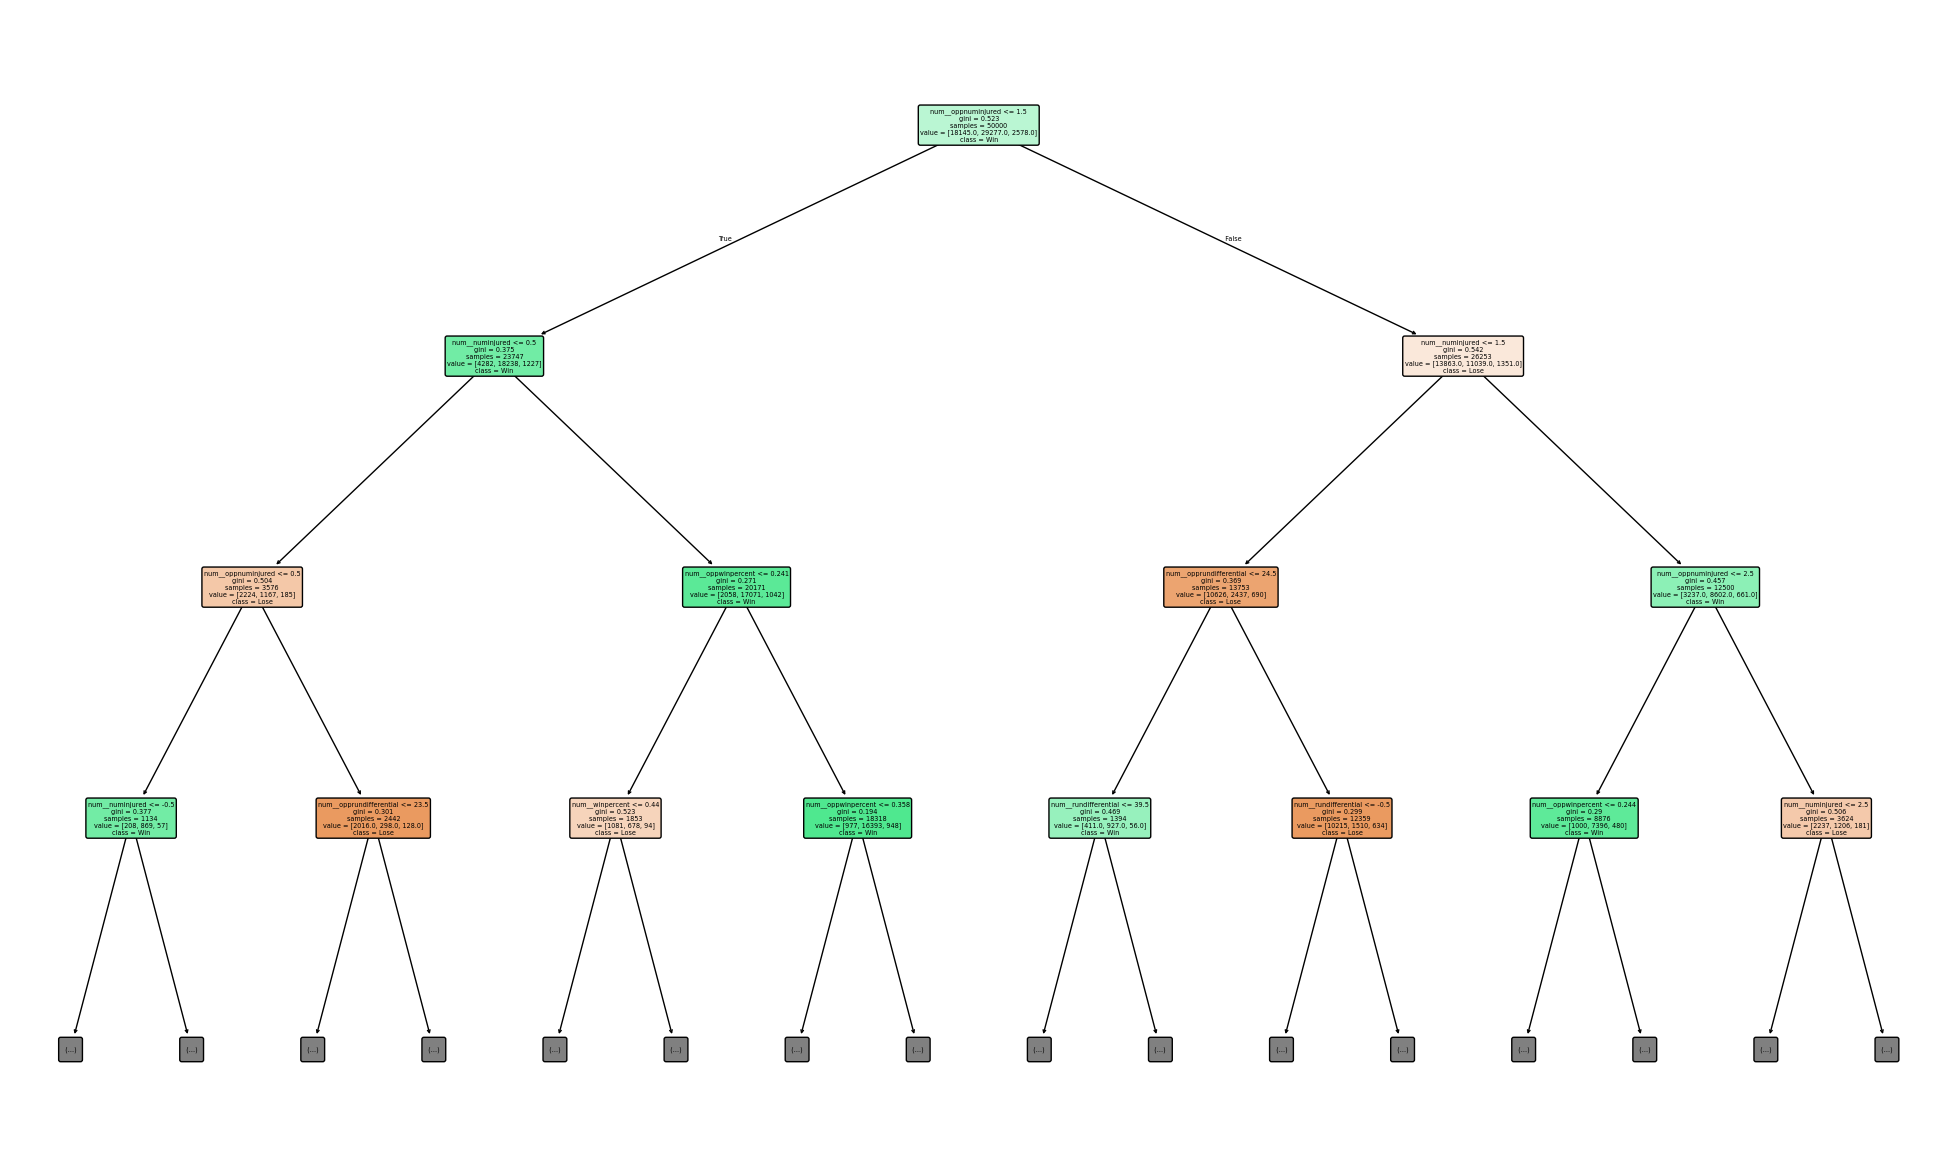

In [20]:
# visualization
plt.figure(figsize=(25, 15))
plot_tree(clf,
          feature_names=preprocessor.get_feature_names_out(),
          class_names=["Lose", "Win"],
          filled=True,
          rounded=True,
          max_depth=3)
plt.savefig("decision_tree.png", bbox_inches='tight', dpi=300)
plt.show()